<h1><font color='green'><center>Two Sigma Connect: Rental Listing Inquiries</center></font></h1>

### Dataset  - https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/overview/description

<h3><center>Overview</center></h3>

Finding the perfect place to call your new home should be more than browsing through endless listings. RentHop makes apartment search smarter by using data to sort rental listings by quality. But while looking for the perfect apartment is difficult enough, structuring and making sense of all available real estate data programmatically is even harder. Two Sigma and RentHop, a portfolio company of Two Sigma Ventures, invite Kagglers to unleash their creative engines to uncover business value in this unique recruiting competition.

Two Sigma invites you to apply your talents in this recruiting competition featuring rental listing data from RentHop. Kagglers will predict the number of inquiries a new listing receives based on the listing’s creation date and other features. Doing so will help RentHop better handle fraud control, identify potential listing quality issues, and allow owners and agents to better understand renters’ needs and preferences.

Two Sigma has been at the forefront of applying technology and data science to financial forecasts. While their pioneering advances in big data, AI, and machine learning in the financial world have been pushing the industry forward, as with all other scientific progress, they are driven to make continual progress. This challenge is an opportunity for competitors to gain a sneak peek into Two Sigma's data science work outside of finance.

<h3><center>Data description</center></h3>

You will predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

The **target variable**, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site. 

### File description
train.json - the training set

### Data fields

<li>bathrooms: number of bathrooms</li>
<li>bedrooms: number of bedrooms</li>
<li>building_id</li>
<li>created</li>
<li>description</li>
<li>display_address</li>
<li>features: a list of features about this apartment</li>
<li>latitude</li>
<li>listing_id</li>
<li>longitude</li>
<li>manager_id</li>
<li>photos: a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip.</li>
<li>price: in USD</li>
<li>street_address</li>
<li>interest_level: this is the target variable. It has 3 categories: 'high', 'medium', 'low'</li>

### Evaluation metric

Submissions are evaluated using the multi-class logarithmic loss. Each listing has one true class. For each listing, you must submit a set of predicted probabilities (one for every listing). The formula is then,

\begin{equation*}
{logloss} = \frac{-1}{N} \sum_{i=1}^N \sum_{j=1}^M y_ij log({p_ij})
\end{equation*}


where N is the number of listings in the test set, M is the number of class labels (3 classes),  log is the natural logarithm, yij is 1 if observation i belongs to class j and 0 otherwise, and pij is the predicted probability that observation i belongs to class j.

The submitted probabilities for a given listing are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with max(min(p,1−10−15),10−15).

### 1. Importing the required libraries

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

import re
from collections import Counter
from nltk.stem import porter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from datetime import datetime
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [6]:
!unzip train.json.zip

Archive:  train.json.zip
  inflating: train.json              


### 2. Loading the dataset

In [2]:
dataset= pd.read_json('train.json')
dataset.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low


In [3]:
dataset.shape

(49352, 15)

Our dataset has close to 49K datapoints and there are 15 columns

In [4]:
dataset.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object')

#### Checking the class imbalance

In [5]:
dataset.interest_level.value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

1. The maximum no of class points belong to the low class followed by medium and then high
2. This dataset set is an imbalanced one

#### Basic statistics about the data

In [5]:
dataset.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


**Analysis on the above:**
1. Bathrooms
    1. As the 75th percentile of the bathrooms feature is 1, we can say that more than 75% of the data is less than equal to 1.
    2. The max no of bathrooms amongst the datapoints present is 10.
    3. The average of bathrooms feature is 1.2
2. Bedrooms
    1. The median of this datapoint is 1, that means around 50% of the datapoints or more have 0 or 1 as the no of bedrooms.
    2. As the standard deviation for the bedrooms feature is more than that of the bathrooms , it is safe to say that the data variabliity for the bedrooms is more than that of the bathrooms
3. Lattitude and Longitude
    1. We see that there is a low variability for the lattitudes and longitudes which means that the presence of outliers may not be there as the standard deviation gets skewed in the presence if outliers , also we know that the geographical location of the rentals may be closeby.

#### Checking the number of nulls in the data

In [6]:
dataset.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

There are no null values in this dataset

### 1. Univariate analysis for the bathroom feature

In [7]:
dataset['bathrooms'].describe()

count    49352.00000
mean         1.21218
std          0.50142
min          0.00000
25%          1.00000
50%          1.00000
75%          1.00000
max         10.00000
Name: bathrooms, dtype: float64

In [8]:
dataset['bathrooms'].unique()

array([ 1.5,  1. ,  2. ,  3.5,  3. ,  2.5,  0. ,  4. ,  4.5, 10. ,  5. ,
        6. ,  6.5,  5.5,  7. ])

In [9]:
print('The  no of unique bathrooms in our dataset {}'.format(len(dataset['bathrooms'].unique())))

The  no of unique bathrooms in our dataset 15


In [10]:
dataset['bathrooms'].value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
6.5         1
10.0        1
7.0         1
Name: bathrooms, dtype: int64

From the data above it is seen that there are an extremly low no of houses (12 datapoints) where the no of bathrooms is greater than 5

#### Line plot with quantiles and percentiles in the data

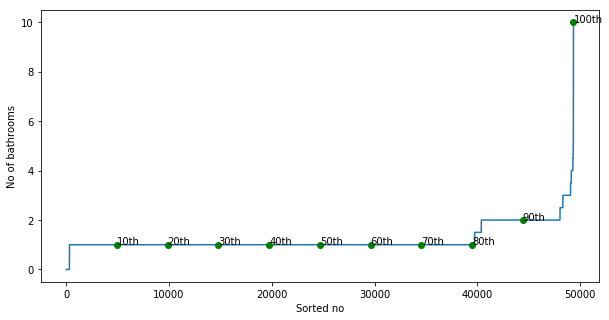

In [11]:
plt.figure(figsize=(10,5))
plt.plot(range(len(dataset['bathrooms'])), dataset['bathrooms'].sort_values())
for i in range(10,101,10):
    plt.plot(int(np.percentile(range(len(dataset['bathrooms'])), i)), np.percentile(dataset.bathrooms,i),color='green', marker='o', label='percentiles')
    plt.annotate(str(i) + 'th',(int(np.percentile(range(len(dataset['bathrooms'])), i)), np.percentile(dataset.bathrooms,i)) )
plt.xlabel('Sorted no')
plt.ylabel('No of bathrooms')
plt.show()

From the line plot above it can be inferred that the 80th percentile of the bathrooms is 1 and the 90th percentile is 2

Checking the data from the 99th to the 100th percentile mark below:

In [53]:
for i in np.arange(99,100,.1):
    print('The {}th percentile value for the bathroom feature is {}'.format(np.round(i,1), np.percentile(dataset['bathrooms'],i )))

The 99.0th percentile value for the bathroom feature is 3.0
The 99.1th percentile value for the bathroom feature is 3.0
The 99.2th percentile value for the bathroom feature is 3.0
The 99.3th percentile value for the bathroom feature is 3.0
The 99.4th percentile value for the bathroom feature is 3.0
The 99.5th percentile value for the bathroom feature is 3.5
The 99.6th percentile value for the bathroom feature is 4.0
The 99.7th percentile value for the bathroom feature is 4.0
The 99.8th percentile value for the bathroom feature is 4.0
The 99.9th percentile value for the bathroom feature is 4.5


From the above we can conclude that even the 99.9th percentile of the data is 4.5 , so the points above 4.5 can be considered as outliers, which is also logical as hardly any rentals will have more than 4 bathrooms.
<p>And we also see that around 80% of the rentals have 1 bathroom in the rentals</p>

#### Cheking the distribution of the bathrooms feature

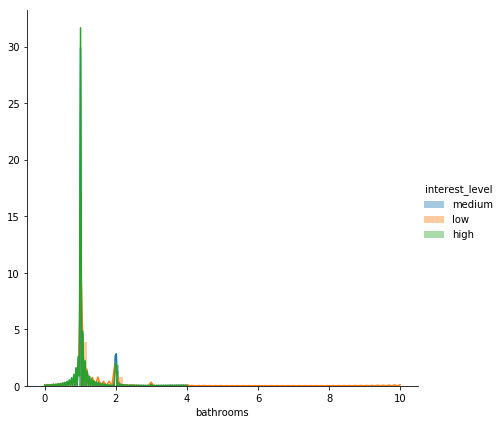

In [27]:
sns.FacetGrid(dataset,hue='interest_level', height=6).map(sns.distplot,'bathrooms').add_legend()
plt.show()

1. We see that there is an overlap between the medium, high and low class points. 
2. The outlier points are mostly from the low class
3. The medium points are concentrated around the #2 of bathrooms

### 2. Univariate analysis for the bedroom feature

In [15]:
dataset['bedrooms'].describe()

count    49352.000000
mean         1.541640
std          1.115018
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: bedrooms, dtype: float64

The median point for the bedroom feature is 1 which means around 50% of the datapoints have less than equal to 1 bedroom present in the rentals

In [17]:
## Unique bedrooms in the datset
dataset['bedrooms'].unique()

array([3, 2, 1, 4, 0, 5, 6, 7, 8])

In [18]:
print('The  no of unique bedrooms in our dataset is {}'.format(len(dataset['bedrooms'].unique())))

The  no of unique bedrooms in our dataset is 9


In [19]:
dataset['bedrooms'].value_counts()

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
8        2
7        2
Name: bedrooms, dtype: int64

#### Line plot with quantiles and percentiles in the data

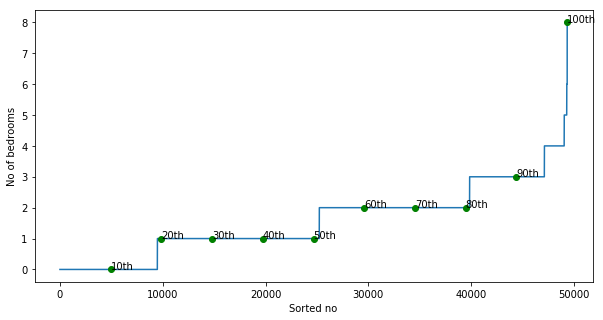

In [21]:
plt.figure(figsize=(10,5))
plt.plot(range(len(dataset['bedrooms'])), dataset['bedrooms'].sort_values())
for i in range(10,101,10):
    plt.plot(int(np.percentile(range(len(dataset['bedrooms'])), i)), np.percentile(dataset.bedrooms,i),color='green', marker='o', label='percentiles')
    plt.annotate(str(i) + 'th',(int(np.percentile(range(len(dataset['bedrooms'])), i)), np.percentile(dataset.bedrooms,i)) )
plt.xlabel('Sorted no')
plt.ylabel('No of bedrooms')
plt.show()

Around 60% of the datapoints have 1 -2 bedrooms in the rentals

Checking the data from the 99th to the 100th percentile mark below:

#### Cheking the distribution of the bedrooms feature

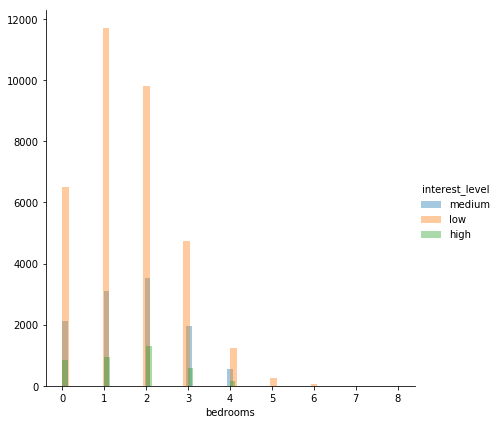

In [33]:
sns.FacetGrid(dataset,hue='interest_level', height=6,).map(sns.distplot,'bedrooms', kde=False).add_legend()
plt.show()

1. We see that there is an overlap between the medium, high and low class points. 
2. The outlier points are mostly from the low class
3. The medium points are concentrated around the #2 of bathrooms

### 3. Univariate analysis for the created feature

In [9]:
def get_duration(date1, date2,): 
    date1= datetime.strptime(date1, '%d/%m/%y')
    date2= datetime.strptime(date2, '%d/%m/%y')
    diff= date2- date1
    return diff.days

#### Utility function

In [23]:
def get_days_months_year(dt, dmy):
    if dmy == 'day':
        return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day
    elif dmy == 'month':
        return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month
    elif dmy == 'year':
        return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year
    return None        

#### Checking the count plot of the created feature

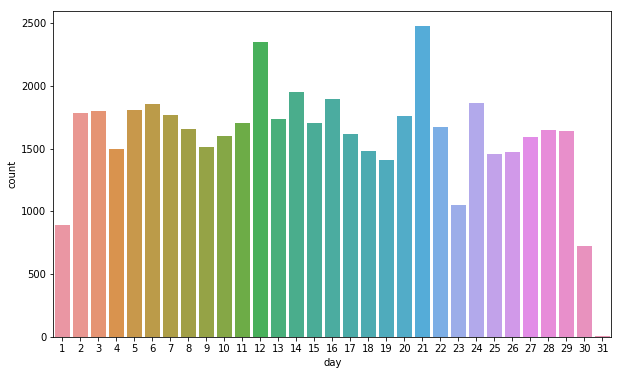

In [32]:
plt.figure(figsize=(10,6))
sns.countplot(dataset['created'].apply(get_days_months_year, dmy='day' ),)
plt.xlabel('day')
plt.show()

#### Checking the months of the created feature

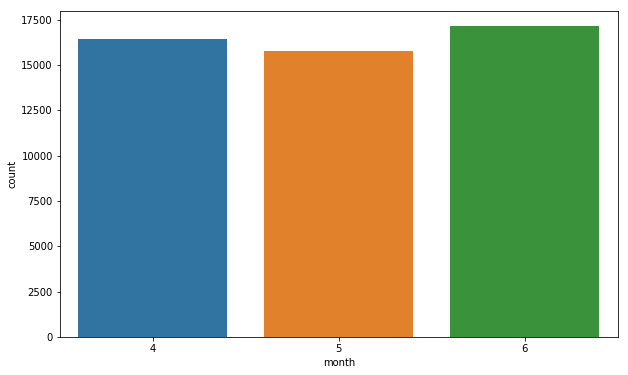

In [33]:
plt.figure(figsize=(10,6))
sns.countplot(dataset['created'].apply(get_days_months_year, dmy='month' ),)
plt.xlabel('month')
plt.show()

#### Checking the year of the created feature

In [41]:
print(dataset['created'].apply(get_days_months_year, dmy='year' ).unique())

[2016]


1. The distribution of the days diesnt seem to follow any specifickind of a distribution and the most no of days when the rentals were created are 21st and the 12th.
2. The rentals seem to have been created in the year of 2016.
3. The months when the rental was created are April , May and June.
3. The distribution of the months seems to be tending to a uniform distribution.

### 4. Univariate analysis of the description feature

#### Text preprocessing

1. Removing the html tags
2. Removing the special characters
3. Lowercasing the words 
4. Removing the stopwords
5. Stemming

In [69]:
stop_eng= stopwords.words('english')
stemmr= SnowballStemmer('english')
def clean_data(text):
    ## Removing the html tags
    soup = BeautifulSoup(text)
    text= soup.get_text()
    
    ##Removing the special characters
    text = re.sub('[^a-zA-Z0-9 ]',' ', text )
    
    ##Lowercasing, stemming and removing the stopwords
    text= word_tokenize(text)
    
    text= ' '.join([stemmr.stem(i.lower()) for i in text if i not in stop_eng])
    return text

In [72]:
dataset['cleaned_description']= dataset['description'].apply(clean_data)

In [130]:
print('The no of datapoints for which the description is not present is {}'.format(len(dataset[dataset['cleaned_description'] == ''])))

The no of datapoints for which the description is not present is 3667


#### Creating word clouds for different classes

In [97]:
def create_word_cloud(df, feature,class_feature, class_name):
    df= df[df[class_feature] == class_name]
    
    listoftokens= [word for doc in df[feature].values for word in doc.split()]
    print("The word cloud texts of class '{}'".format(class_name.upper()))
    wc=WordCloud(width=1200,height=600).generate_from_frequencies(dict(Counter(listoftokens).most_common(200)))
    plt.figure(figsize=(10,8))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

The word cloud texts of class 'MEDIUM'


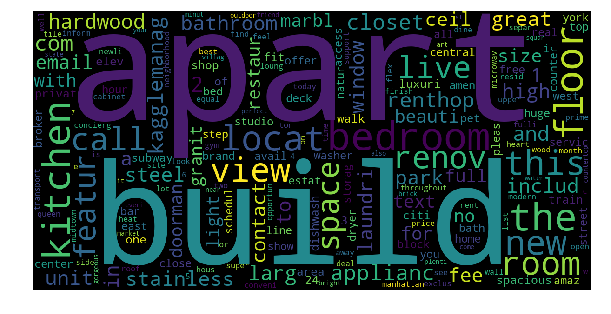


************

The word cloud texts of class 'LOW'


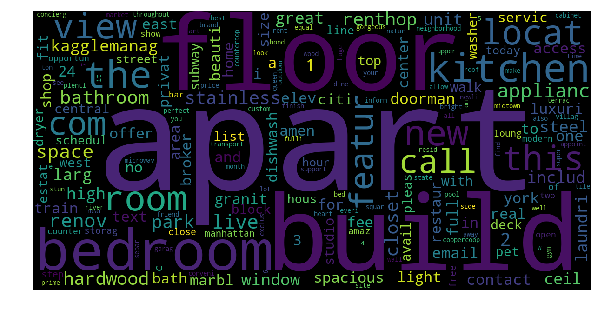


************

The word cloud texts of class 'HIGH'


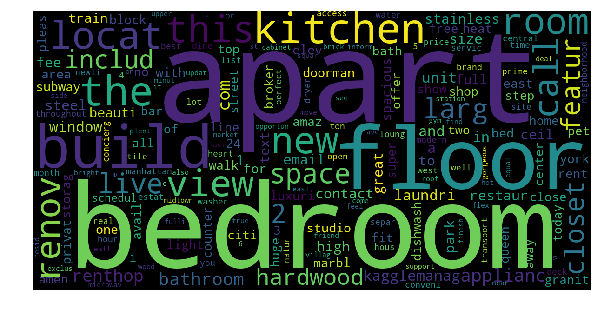


************



In [99]:
for i in dataset.interest_level.unique():
    create_word_cloud(df= dataset, feature='cleaned_description',class_feature='interest_level' , class_name=i)
    print('\n************\n')

1. From the wordclouds of the cleaned texts of the different classes(low, medium and high) we do not see any major difference in the words present
2. The most common words being apart, bedroom, build , kitchen, floor etc

### 5. Univariate analysis of the display address feature

In [106]:
dataset['display_address'].value_counts()[dataset['display_address'].value_counts()> 200]

Broadway             438
East 34th Street     355
Second Avenue        349
Wall Street          332
West 37th Street     287
West Street          258
First Avenue         244
Gold Street          241
Washington Street    237
York Avenue          228
John Street          214
Water Street         214
Name: display_address, dtype: int64

The following count plot represents the top 20 addresses present in our dataset

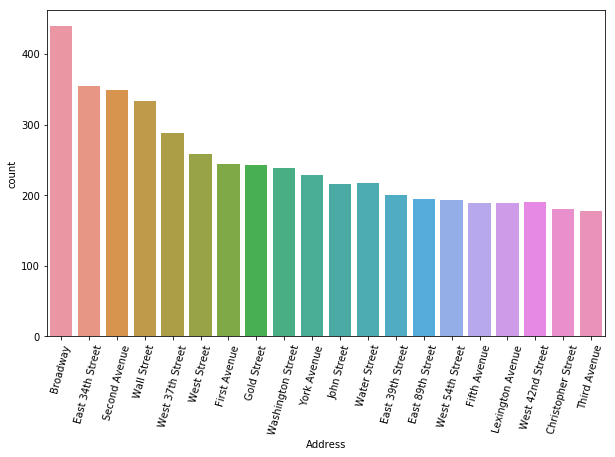

In [113]:
plt.figure(figsize=(10,6))
sns.countplot(dataset['display_address'].apply(lambda x: re.sub('[^a-zA-Z0-9 ]','',x)),order= dataset.display_address.value_counts().iloc[:20].index )
plt.xlabel('Address')
plt.xticks(rotation=75)
plt.show()

As we can observe from the above graph that Broadway has the highest no of addresses in our dataset, followed by East Street and Second Avenue

### 6. Univariate analysis of the street address feature

The following data is the top 10 street addresses present in our dataset

In [116]:
dataset['street_address'].value_counts()[:10]

3333 Broadway           174
505 West 37th Street    167
200 Water Street        160
90 Washington Street    142
100 Maiden Lane         131
401 East 34th Street    129
2 Gold Street           120
1 West Street           119
100 John Street         115
95 Wall Street          106
Name: street_address, dtype: int64

In [118]:
print('The no of unique street addresses present in our dataset is {}'.format(len(dataset['street_address'].unique())))

The no of unique street addresses present in our dataset is 15358


In [122]:
print('The no of street addresses present only once in our dataset are {}'.format(np.sum(dataset['street_address'].value_counts() ==1)))

The no of street addresses present only once in our dataset are 8949


The following count plot represents the top 20 street addresses present in our dataset

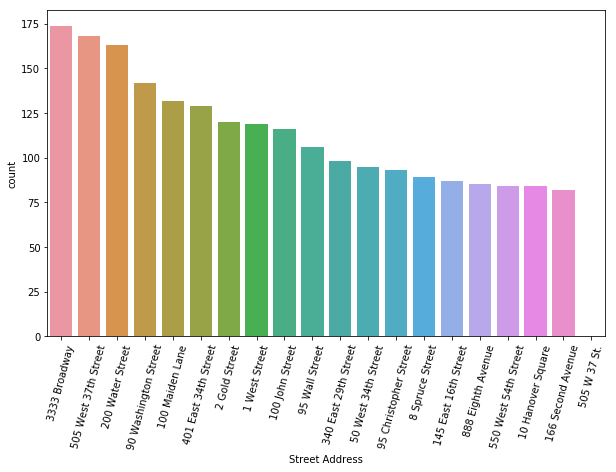

In [123]:
plt.figure(figsize=(10,6))
sns.countplot(dataset['street_address'].apply(lambda x: re.sub('[^a-zA-Z0-9 ]','',x)),order= dataset.street_address.value_counts().iloc[:20].index )
plt.xlabel('Street Address')
plt.xticks(rotation=75)
plt.show()

### 7. Univariate analysis of the features feature

In [136]:
features= [word.lower() for sublist in dataset.features for word in sublist ]

The following are the 20 most common features present in the dataset

In [139]:
Counter(features).most_common(20)

[('elevator', 26273),
 ('hardwood floors', 23558),
 ('cats allowed', 23540),
 ('dogs allowed', 22035),
 ('doorman', 20967),
 ('dishwasher', 20806),
 ('laundry in building', 18944),
 ('no fee', 18079),
 ('fitness center', 13257),
 ('laundry in unit', 9435),
 ('pre-war', 9149),
 ('roof deck', 6555),
 ('outdoor space', 5270),
 ('dining room', 5150),
 ('high speed internet', 4299),
 ('balcony', 3058),
 ('swimming pool', 2730),
 ('new construction', 2608),
 ('terrace', 2313),
 ('exclusive', 2167)]

**Elevator, hardwood floors, cats allowed , dogs allowed, doorman , dishwasher etc** are some of the most common occuring features present in our datset

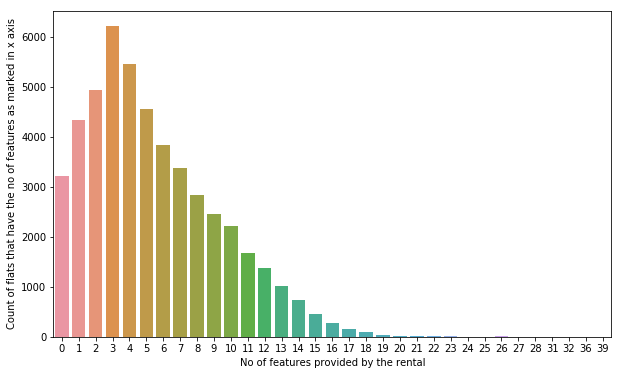

In [148]:
plt.figure(figsize=(10,6))
sns.countplot(dataset['features'].apply(len))
plt.xlabel('No of features provided by the rental')
plt.ylabel('Count of flats that have the no of features as marked in x axis')
plt.show()

1. From the above graph we can conclude that the maximum no of rentals provide 3 features
2. A lot of apartments also have no features mentioned 
3. A very few rentals have features above 25

### 8. Analysis of latitudes and longitudes using the folium module

In [156]:
# creating a map with the a base location
base_coor = folium.Map(location=[40.73, -73.99], tiles='Stamen Toner')

sample_locations= dataset.head(1000)

for i, j in sample_locations.iterrows():
    folium.Marker(list((j['latitude'], j['longitude']))).add_to(base_coor)

The following map shows some of the coordinates based on the latitudes and longitudes as present in the dataset

In [157]:
display(base_coor)

#### Creating a box plot for the latitude feature:

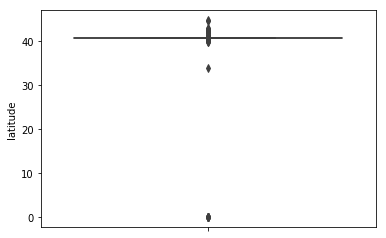

In [152]:
sns.boxplot(y=dataset['latitude'])
plt.show()

From the above box plot we can infer that 0 may be an outlier point in the latitude feature

#### Creating a box plot for the longitude feature:

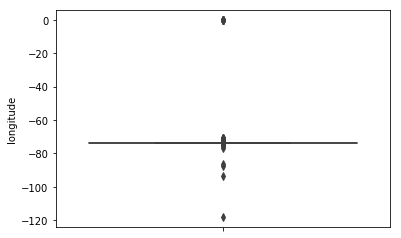

In [153]:
sns.boxplot(y=dataset['longitude'])
plt.show()

We can infer from the box plot of the longitude feature that there are a few points present near 0 and -120 which may be outliers